# Model Creation and Training

## Importing the necessary modules

In [1]:
## basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

## Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv("../Data/final_train.csv")

### Show top 5 rows

In [3]:
df.head()

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,nb_terminals,x_terminal_id,y_terminal_id,date,month,day,hour,dayofweek
0,59383,323,217,4.60,0,84.515409,38.276422,7.353061,3.676530,3.324124,19,80.316334,40.239252,2021-08-01,8,1,0,Sunday
1,59384,6,429,8.61,0,11.827443,63.992102,18.618562,9.309281,3.778676,16,15.172487,63.912685,2021-08-01,8,1,0,Sunday
2,59385,714,1011,64.00,0,75.221083,94.991427,82.620413,41.310207,3.723765,13,74.196424,98.288079,2021-08-01,8,1,0,Sunday
3,59386,266,1969,12.72,0,51.122179,8.329098,9.852171,4.926085,3.862067,15,51.950635,6.563484,2021-08-01,8,1,0,Sunday
4,59387,890,1482,98.88,0,62.777887,31.405270,83.660035,41.830018,3.128315,20,62.417972,26.483666,2021-08-01,8,1,0,Sunday


## Treating outliers

We know there are outliers in TX_AMOUNT columns, so we need to treat them

<Axes: xlabel='TX_AMOUNT'>

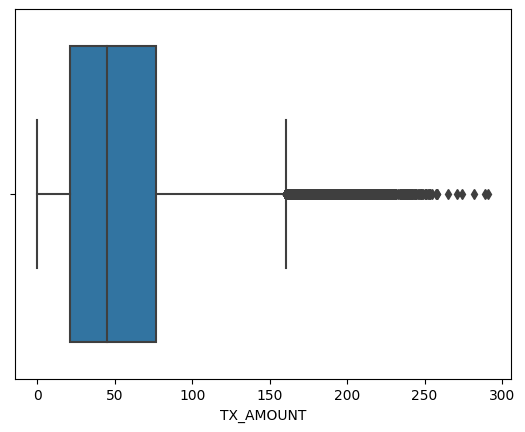

In [4]:
sns.boxplot(data = df, x=df['TX_AMOUNT'])

### Replacing the outliers with the median

Q1 = 21.13 Q2 =  44.77 Q3 =  76.85
IQR =  55.72
upper 160.43
lower -62.45


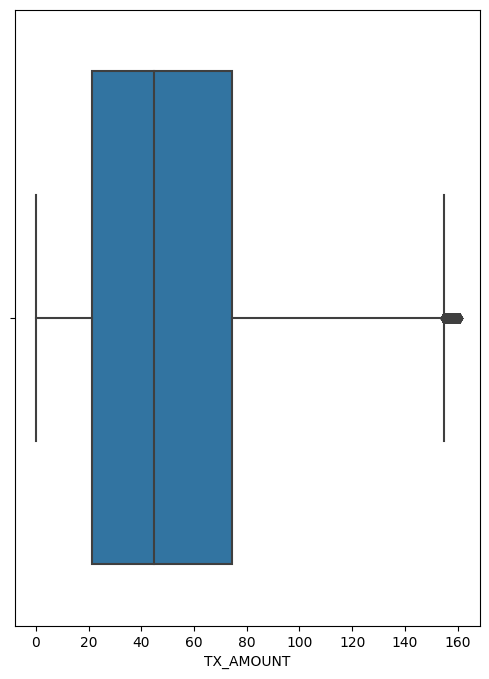

In [5]:
Q1 = np.percentile(df['TX_AMOUNT'], 25)
Q2 = np.percentile(df['TX_AMOUNT'], 50)
Q3 = np.percentile(df['TX_AMOUNT'], 75)
IQR = Q3 - Q1        
print('Q1 =',Q1,'Q2 = ',Q2,'Q3 = ',Q3)
print('IQR = ',IQR)

upper_val = Q3 + (1.5 * IQR)
print('upper', upper_val)
lower_val = Q1 - (1.5 * IQR)
print('lower', lower_val)

df.loc[df['TX_AMOUNT'] > upper_val, 'TX_AMOUNT'] = np.median(df['TX_AMOUNT'])
df.loc[df['TX_AMOUNT'] < lower_val, 'TX_AMOUNT'] = np.median(df['TX_AMOUNT'])
        
fig = plt.figure(figsize = (6,8))
sns.boxplot(data = df,x= 'TX_AMOUNT')
plt.xticks(rotation = 'horizontal')
plt.show()

## Feature Selection

In [6]:
features = ['TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID', 'dayofweek', 'day', 'hour', 'month', 'x_customer_id', 'y_customer_id', 'nb_terminals',
            'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'TX_AMOUNT']
target = ['TX_FRAUD']

## PREAPRING X and y variables

In [7]:
X = df[features]
y = df[target]
print(X.head(2))
print(y.head(2))

   TRANSACTION_ID  CUSTOMER_ID  TERMINAL_ID dayofweek  day  hour  month   
0           59383          323          217    Sunday    1     0      8  \
1           59384            6          429    Sunday    1     0      8   

   x_customer_id  y_customer_id  nb_terminals  mean_amount  std_amount   
0      84.515409      38.276422            19     7.353061    3.676530  \
1      11.827443      63.992102            16    18.618562    9.309281   

   mean_nb_tx_per_day  TX_AMOUNT  
0            3.324124       4.60  
1            3.778676       8.61  
   TX_FRAUD
0         0
1         0


## Handling Imbalance

### SMOTE

In [8]:
from imblearn.over_sampling import SMOTENC

In [9]:
n_cat_index = np.array([3])
smote = SMOTENC(categorical_features=n_cat_index, random_state=42, n_jobs=True)
X_n, y_n = smote.fit_resample(X,y)
X_n.shape, y_n.shape

((569298, 14), (569298, 1))

In [10]:
y_n.value_counts()

TX_FRAUD
0           284649
1           284649
Name: count, dtype: int64

## Preprocessing

In [11]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [12]:
X = preprocessor.fit_transform(X)

## Model Selection

### Models

In [13]:
models = {
    'LogisticRegression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SVC': SVC()
}

### Metrics

In [14]:
metrics = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr') 
}

## Create an Evaluate Function to give all metrics after model Training

In [15]:
from sklearn.model_selection import RepeatedKFold, cross_validate
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    cv_results = cross_validate(model, X, y, cv=cv, scoring=metrics, return_estimator =True)
    print('Model: %s' % model)
    print('Precision: %.3f (%.3f)' % (np.mean(cv_results['test_precision']), np.std(cv_results['test_precision'])))
    print('Recall: %.3f (%.3f)' % (np.mean(cv_results['test_recall']), np.std(cv_results['test_recall'])))
    print('F1: %.3f (%.3f)' % (np.mean(cv_results['test_f1']), np.std(cv_results['test_f1'])))
    print('ROC AUC: %.3f (%.3f)' % (np.mean(cv_results['test_roc_auc']), np.std(cv_results['test_roc_auc'])))
    print('----------------------------------------\n\n')

In [16]:
for name, model in models.items():
    evaluate_model(model, X, y)

Model: LogisticRegression()
Precision: 0.955 (0.001)
Recall: 0.977 (0.000)
F1: 0.966 (0.001)
ROC AUC: 0.500 (0.000)
----------------------------------------


Model: KNeighborsClassifier()
Precision: 0.971 (0.001)
Recall: 0.978 (0.000)
F1: 0.972 (0.001)
ROC AUC: 0.584 (0.006)
----------------------------------------


Model: RandomForestClassifier()
Precision: 0.979 (0.001)
Recall: 0.981 (0.001)
F1: 0.976 (0.001)
ROC AUC: 0.611 (0.008)
----------------------------------------


Model: DecisionTreeClassifier()
Precision: 0.979 (0.001)
Recall: 0.977 (0.001)
F1: 0.978 (0.001)
ROC AUC: 0.772 (0.012)
----------------------------------------


Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
   

## Hyperparameter tuning

In [ ]:
def tuning(model, X, y, params):
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    grid = GridSearchCV(model, params, cv=cv, scoring=metrics, refit='f1', return_train_score=True)
    grid.fit(X, y)
    print('Best score: %.3f' % grid.best_score_)
    print('Best params: %s' % grid.best_params_)

### Random Forest

In [ ]:
## hyperparameters
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1,0:3}, {0:1, 1:4}, {0:1, 1:5}]
}

In [ ]:
tuning(models['RandomForest'], X, y, rf_params)

### Decision Tree

In [ ]:
## hyperparameters
dt_params = {
    'max_depth': [3, 5, 7, 9, 11],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1,0:3}, {0:1, 1:4}, {0:1, 1:5}]
}

In [ ]:
tuning(models['DecisionTree'], X, y, dt_params)